<a href="https://colab.research.google.com/github/pineapple-666/Detect-Sepsis-in-Patients-Before-it-Emerges/blob/main/notebook/Step1_Data_Exploring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

### Importing and splitting the data into training and testing



In [95]:
url = "https://raw.github.com/pineapple-666/Detect-Sepsis-in-Patients-Before-it-Emerges/main/data/train.csv.zip"
raw_data = pd.read_csv(url)
print(raw_data.head(3))

   patient  time    HR  O2Sat   Temp    SBP   MAP   DBP  Resp  EtCO2  ...  \
0    16426     1   NaN    NaN    NaN    NaN   NaN   NaN   NaN    NaN  ...   
1    16426     2  78.0   99.5  35.25  108.5  84.5  69.0  12.0    NaN  ...   
2    16426     3  80.0   99.0  36.20  113.0  87.0  73.0  12.0    NaN  ...   

    WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0   NaN         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
1  14.2         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   
2   NaN         NaN        NaN  57.03     1.0    0.0    1.0        -4.25   

   ICULOS  SepsisLabel  
0     1.0          0.0  
1     2.0          0.0  
2     3.0          0.0  

[3 rows x 43 columns]


In [96]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088197 entries, 0 to 1088196
Data columns (total 43 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   patient           1088197 non-null  int64  
 1   time              1088197 non-null  int64  
 2   HR                980967 non-null   float64
 3   O2Sat             947133 non-null   float64
 4   Temp              369212 non-null   float64
 5   SBP               931096 non-null   float64
 6   MAP               953029 non-null   float64
 7   DBP               749357 non-null   float64
 8   Resp              921122 non-null   float64
 9   EtCO2             41511 non-null    float64
 10  BaseExcess        58822 non-null    float64
 11  HCO3              45312 non-null    float64
 12  FiO2              90753 non-null    float64
 13  pH                75490 non-null    float64
 14  PaCO2             60609 non-null    float64
 15  SaO2              37520 non-null    float64
 16  

In [97]:
raw_data['patient'].unique().size

28235

In [98]:
import random
random.seed(1)
num_patients_20_percent = 28235 * 0.2
random_numbers = random.sample(range(28236), int(num_patients_20_percent))

In [99]:
train_df = raw_data[raw_data['patient'].isin(random_numbers)].copy()
valid_df = raw_data[~raw_data['patient'].isin(random_numbers)].copy()

print(train_df.shape)
print(valid_df.shape)

(217132, 43)
(871065, 43)


In [100]:
total_rows_split = len(train_df) + len(valid_df)
total_rows_raw = len(raw_data)
print(total_rows_split)
print(total_rows_raw)

1088197
1088197


In [101]:
print(train_df.shape[0] / raw_data.shape[0])

0.19953372413267084


### Exploratory data analysis

In [102]:
train_df.head(15)

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,NaN,...,14.2,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,5.0,0.0
5,16426,6,75.0,98.0,36.90,96.0,69.0,56.0,13.0,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,6.0,0.0
6,16426,7,70.0,97.0,36.70,101.0,77.0,63.0,12.0,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,7.0,0.0
7,16426,8,64.0,98.0,36.70,104.0,78.0,64.0,14.0,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,8.0,0.0
8,16426,9,71.0,98.0,36.80,100.0,75.0,61.0,16.0,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,9.0,0.0
9,16426,10,62.0,97.0,36.80,100.0,73.0,59.0,10.0,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,10.0,0.0


In [103]:
train_df.columns

Index(['patient', 'time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp',
       'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST',
       'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [104]:
# Percentage of null values present in all the parameters

null_values = train_df.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
Bilirubin_direct,99.806109
Fibrinogen,99.314242
TroponinI,99.056334
Bilirubin_total,98.469134
Alkalinephos,98.354457
AST,98.342483
Lactate,97.169924
PTT,97.045115
SaO2,96.471731
EtCO2,96.286130


In [105]:
# the features have been removed based on the number of null values and redundancy

# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Bilirubin_direct' -- Total bilirubin is considered instead of Bilirubin_direct
# 'Hgb' -- Hct(Hemoglobin (g/dL)) is considered instead of Hgb(Hemoglobin (g/dL)) Hematocrit≈3×Hemoglobin

columns_drop={'SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2', 'Bilirubin_direct', 'Hgb'}
train_df = train_df.assign(Unit=train_df['Unit1'] + train_df['Unit2'])
train_df_mod = train_df.drop(columns=columns_drop)
train_df_mod.columns

Index(['patient', 'time', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2',
       'AST', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Lactate',
       'Bilirubin_total', 'TroponinI', 'Hct', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Unit'],
      dtype='object')

In [108]:
# the features have been removed based on the number of null values and redundancy

# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Bilirubin_direct' -- Total bilirubin is considered instead of Bilirubin_direct
# 'Hgb' -- Hct(Hemoglobin (g/dL)) is considered instead of Hgb(Hemoglobin (g/dL)) Hematocrit≈3×Hemoglobin

columns_drop={'SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2', 'Bilirubin_direct', 'Hgb'}
train_df = train_df.assign(Unit=train_df['Unit1'] + train_df['Unit2'])
train_df_mod = train_df.drop(columns=columns_drop)
train_df_mod.columns

Index(['patient', 'time', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2',
       'AST', 'BUN', 'Chloride', 'Creatinine', 'Glucose', 'Lactate',
       'Bilirubin_total', 'TroponinI', 'Hct', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Unit'],
      dtype='object')

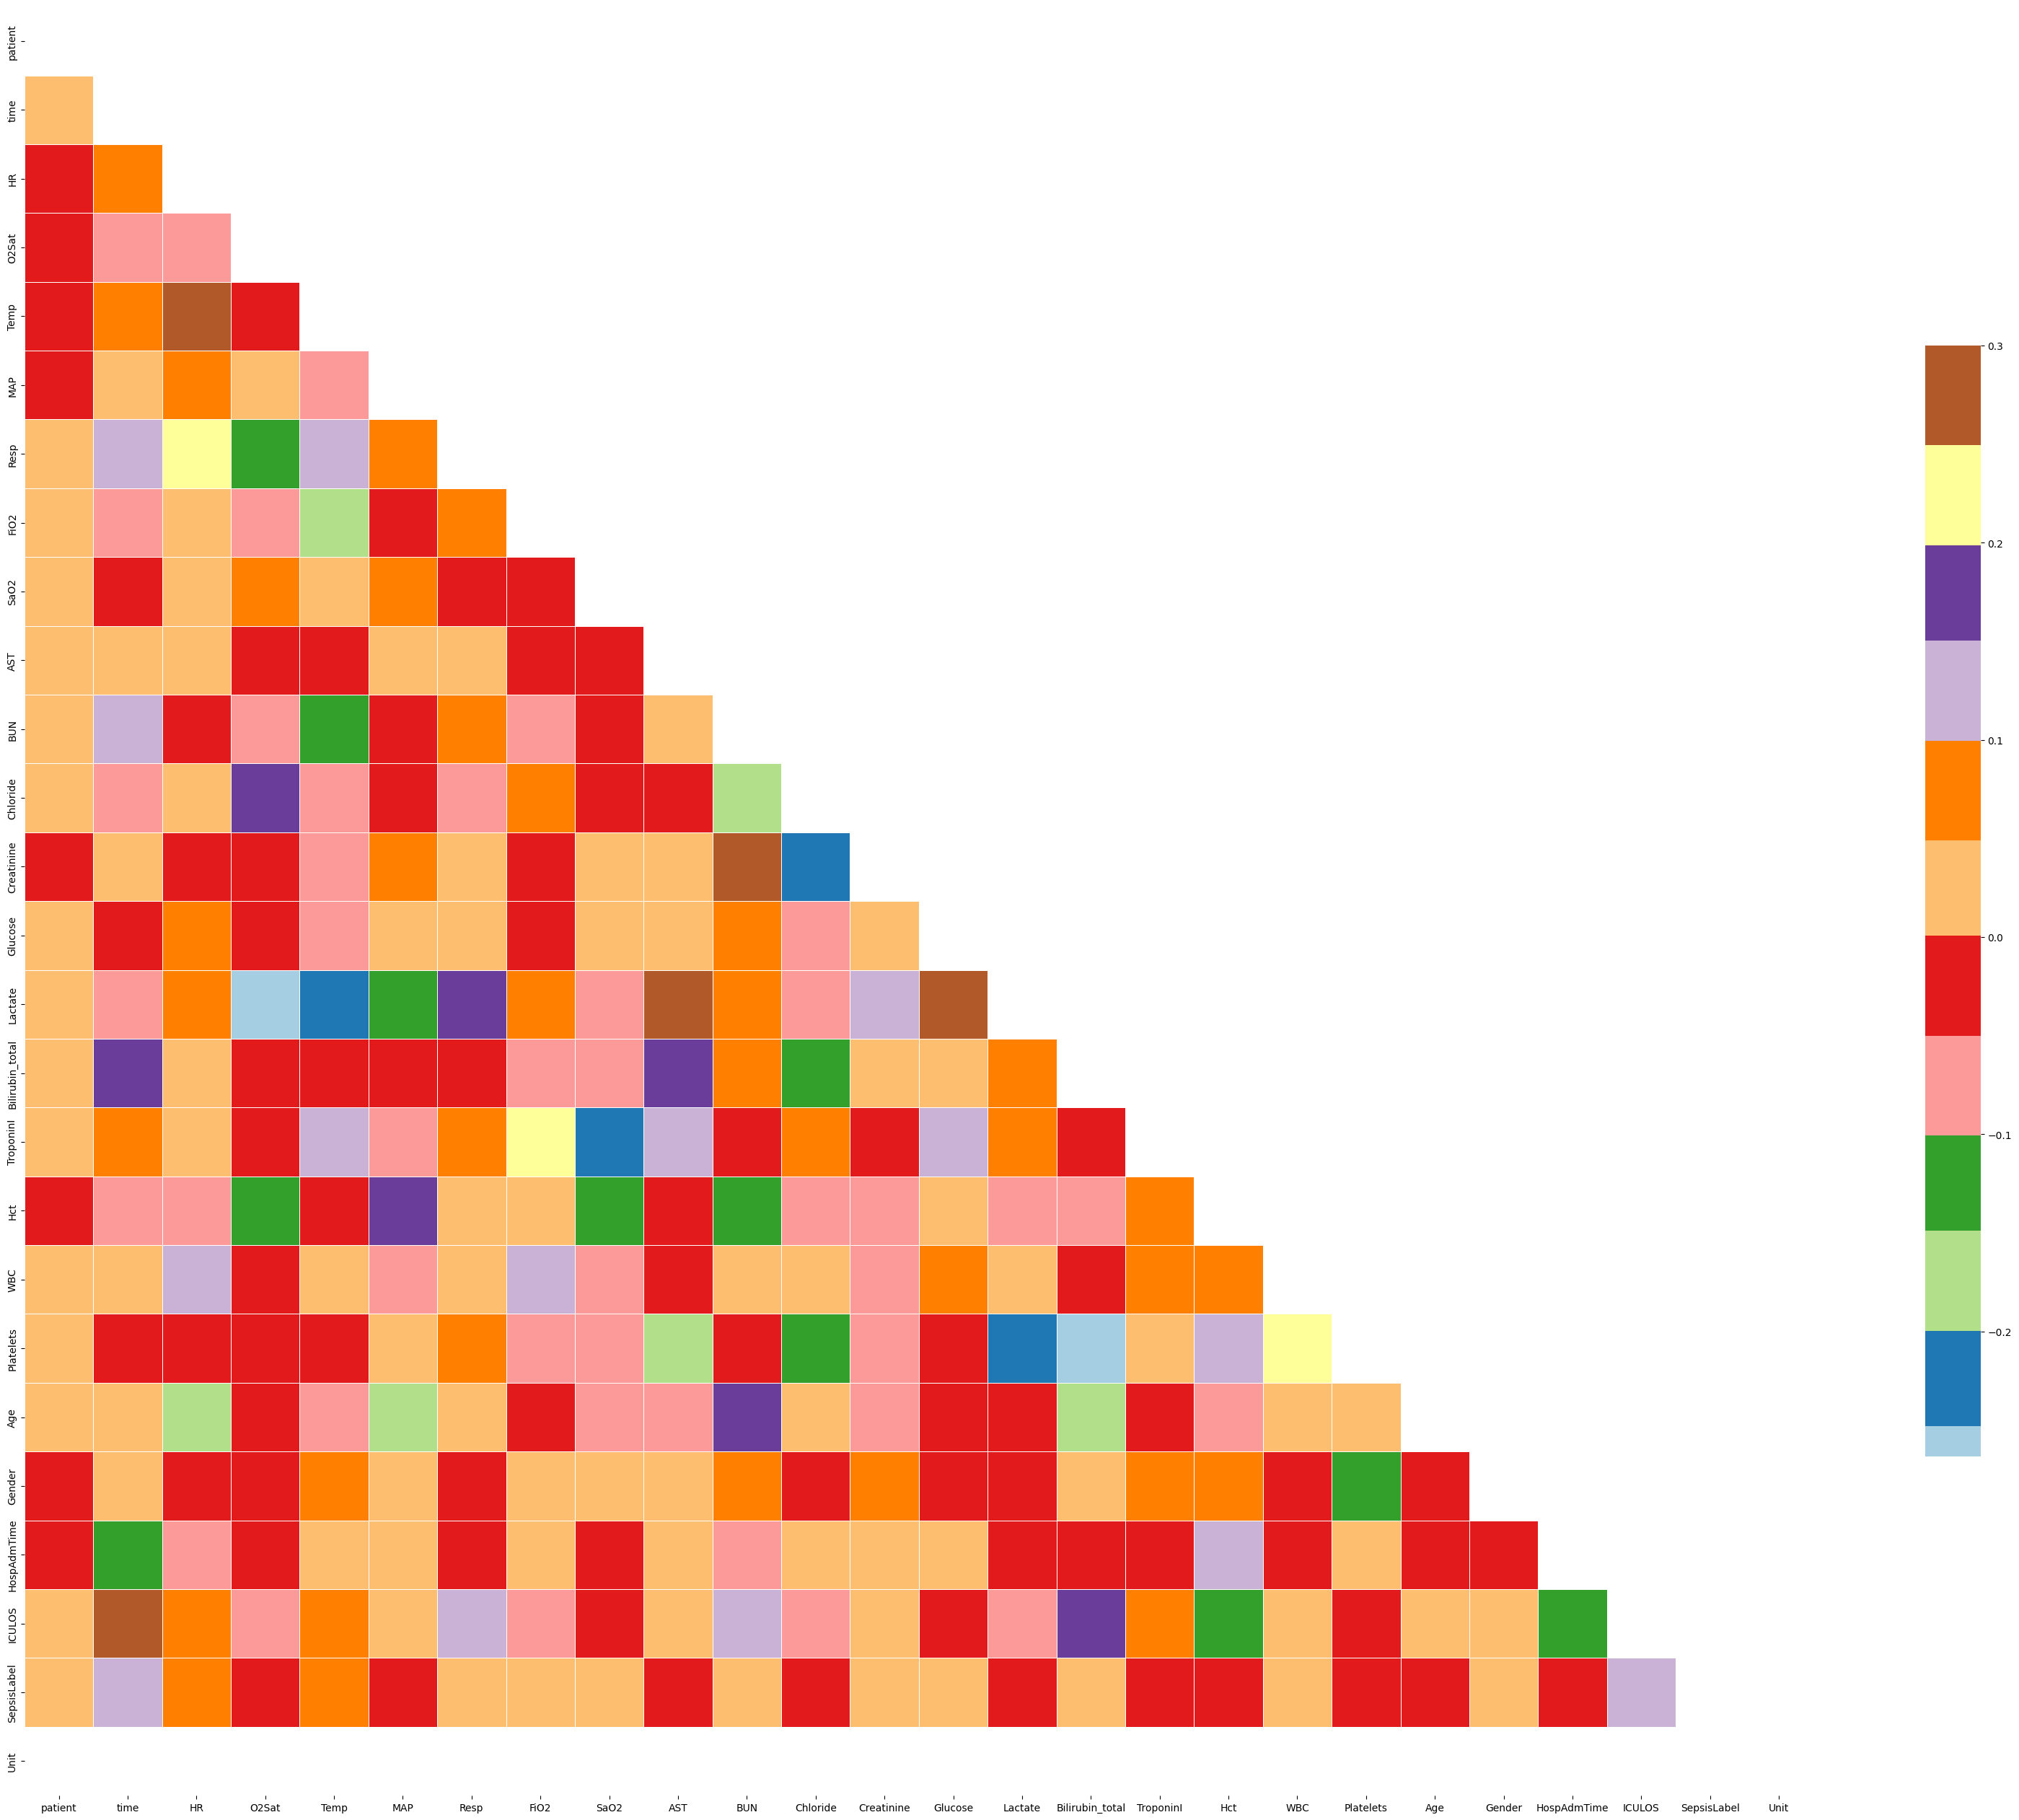

In [109]:
# Function to draw correlation heat map

def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr_matrix(train_df_mod)

In [113]:
corr_values_train_df = train_df_mod.corr()
display(corr_values_train_df)

,patient,time,HR,O2Sat,Temp,MAP,Resp,FiO2,SaO2,AST,...,TroponinI,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Unit
patient,1.000000,0.021075,-0.011055,-0.014198,-0.007678,-0.009061,0.012539,0.008066,0.037776,0.029664,...,0.016021,-0.041227,0.002287,0.000875,0.001204,-0.002509,-0.032062,0.020416,0.006680,NaN
time,0.021075,1.000000,0.050482,-0.051754,0.083005,0.028325,0.112220,-0.055430,-0.004567,0.007976,...,0.050136,-0.096692,0.014148,-0.038101,0.009202,0.021529,-0.112753,0.998844,0.140661,NaN
HR,-0.011055,0.050482,1.000000,-0.070107,0.260114,0.081303,0.217998,0.045335,0.003893,0.028883,...,0.024158,-0.086106,0.136304,-0.006249,-0.167816,-0.031092,-0.052417,0.051151,0.050327,NaN
O2Sat,-0.014198,-0.051754,-0.070107,1.000000,-0.028088,0.028275,-0.140047,-0.076641,0.086610,-0.017561,...,-0.027499,-0.129167,-0.011609,-0.028113,-0.045298,-0.036418,-0.023834,-0.050449,-0.002524,NaN
Temp,-0.007678,0.083005,0.260114,-0.028088,1.000000,-0.051230,0.120467,-0.188201,0.020921,-0.028100,...,0.114129,-0.033365,0.025873,-0.015495,-0.084290,0.058332,0.003150,0.086868,0.064036,NaN
MAP,-0.009061,0.028325,0.081303,0.028275,-0.051230,1.000000,0.051805,-0.034774,0.090731,0.002405,...,-0.069190,0.180360,-0.056792,0.034972,-0.170930,0.004653,0.021774,0.023050,-0.018974,NaN
Resp,0.012539,0.112220,0.217998,-0.140047,0.120467,0.051805,1.000000,0.099074,-0.003419,0.000666,...,0.051319,0.000699,0.048397,0.049597,0.034069,-0.015252,-0.009988,0.110934,0.047200,NaN
FiO2,0.008066,-0.055430,0.045335,-0.076641,-0.188201,-0.034774,0.099074,1.000000,-0.026648,-0.003271,...,0.244102,0.030461,0.140154,-0.050798,0.000182,0.025905,0.002413,-0.054276,0.015286,NaN
SaO2,0.037776,-0.004567,0.003893,0.086610,0.020921,0.090731,-0.003419,-0.026648,1.000000,-0.013765,...,-0.234470,-0.100844,-0.098466,-0.073117,-0.083298,0.031578,-0.044577,-0.009039,0.024708,NaN
AST,0.029664,0.007976,0.028883,-0.017561,-0.028100,0.002405,0.000666,-0.003271,-0.013765,1.000000,...,0.123026,-0.017851,-0.015130,-0.176724,-0.073063,0.043220,0.028850,0.012354,-0.020219,NaN


In [122]:
corr_threshold = 0.6
high_corr_pairs = []

# Iterate through the correlation matrix for train_df_mod
for i in range(len(corr_values_train_df.columns)):
    for j in range(i + 1, len(corr_values_train_df.columns)): # Start from i+1 to avoid self-correlation and duplicates
        if abs(corr_values_train_df.iloc[i, j]) > corr_threshold:
            high_corr_pairs.append({
                'Feature 1': corr_values_train_df.columns[i],
                'Feature 2': corr_values_train_df.columns[j],
                'Correlation': corr_values_train_df.iloc[i, j]
            })

# Convert to DataFrame for better display
high_corr_df = pd.DataFrame(high_corr_pairs)
display(high_corr_df.sort_values(by='Correlation', ascending=False))

,Feature 1,Feature 2,Correlation
0,time,ICULOS,0.998844
1,BUN,Creatinine,0.620102


### Imputation

In [123]:
train_df_impute = train_df_mod.copy()
columns_impute = list(train_df_impute.columns)

In [124]:
# bfill and ffill for imputing
# bfill first because usually a record approaching the end is usually worse, as the development of an illness

grouped_by_patient = train_df_impute.groupby('patient')
train_df_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

/tmp/ipython-input-1461796861.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [125]:
train_df_impute.head()

patient  time    HR  O2Sat  Temp   MAP  Resp  FiO2  SaO2  AST  \
patient                                                                         
19      794054       19     1  97.0   97.0  36.0  84.0  26.0   NaN   NaN  NaN   
        794055       19     2  97.0   97.0  36.0  84.0  26.0   NaN   NaN  NaN   
        794056       19     3  91.0   95.0  36.0  86.0  27.0   NaN   NaN  NaN   
        794057       19     4  97.0   98.0  36.0  78.0  27.0   NaN   NaN  NaN   
        794058       19     5  88.5   96.5  36.0  93.5  31.0   NaN   NaN  NaN   

                ...  TroponinI   Hct   WBC  Platelets   Age  Gender  \
patient         ...                                                   
19      794054  ...        NaN  43.0  10.5      174.0  78.0     1.0   
        794055  ...        NaN  43.0  10.5      174.0  78.0     1.0   
        794056  ...        NaN  43.0  12.1      164.0  78.0     1.0   
        794057  ...        NaN  43.0  12.1      164.0  78.0     1.0   
        794058  ...        NaN  43.0  12.1      164.0  78.0     1.0   

                HospAdmTime  ICULOS  SepsisLabel  Unit  
patient                                                 
19      794054        -7.49     1.0          0.0   1.0  
        794055        -7.49     2.0          0.0   1.0  
        794056        -7.49     3.0          0.0   1.0  
        794057        -7.49     4.0          0.0   1.0  
        794058        -7.49     5.0          0.0   1.0  

[5 rows x 26 columns]

In [127]:
# Now let's check the remaining proportion of missing values

null_values = train_df_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
TroponinI,81.989757
Lactate,62.639316
SaO2,62.362987
AST,58.420684
Bilirubin_total,58.403644
FiO2,49.396220
Chloride,44.652101
Unit,39.390785
WBC,4.194683
Platelets,4.118693


In [129]:
# dropping all the columns with null values more than 25%

null_col = ['TroponinI', 'Lactate','AST','SaO2', 'Bilirubin_total', 'FiO2','Chloride','Unit']
train_df_impute = train_df_impute.drop(columns=null_col)
train_df_impute.columns

Index(['patient', 'time', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN',
       'Creatinine', 'Glucose', 'Hct', 'WBC', 'Platelets', 'Age', 'Gender',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')


### Keep One Record for Each Patient:
####SepsisLabel == 1
Patients:For patients who show SepsisLabel = 1 at any point, I will identify their very first record where SepsisLabel becomes 1 (ordered by time) and keep only that record.
####Never SepsisLabel == 1
Patients: For patients who never have SepsisLabel = 1, I will average all their records to create a single representative record for each of them.


In [135]:
sepsis_patients_ids = train_df_impute[train_df_impute['SepsisLabel'] == 1]['patient'].unique()
print(len(sepsis_patients_ids))

420


In [131]:
train_df_impute_reset = train_df_impute.reset_index(level=0, drop=True)

# 1. Filter train_df_impute for patients identified as sepsis-positive
sepsis_positive_records = train_df_impute_reset[train_df_impute_reset['patient'].isin(sepsis_patients_ids)].copy()

# 2. Further filter to keep only records where SepsisLabel is equal to 1
sepsis_positive_records_only = sepsis_positive_records[sepsis_positive_records['SepsisLabel'] == 1].copy()

# 3. Group by 'patient' and select the row with the minimum 'time' value
earliest_sepsis_records = sepsis_positive_records_only.loc[sepsis_positive_records_only.groupby('patient')['time'].idxmin()]

# Display the shape and head of the resulting DataFrame
print(f"Shape of earliest_sepsis_records: {earliest_sepsis_records.shape}")
print("Head of earliest_sepsis_records:")
display(earliest_sepsis_records.head())

Shape of earliest_sepsis_records: (420, 18)
Head of earliest_sepsis_records:


,patient,time,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
411506,190,4,65.0,98.0,36.33,97.0,13.0,40.0,1.20,100.0,35.8,7.3,145.0,87.60,1.0,-0.02,4.0,1.0
770608,344,42,93.0,97.0,38.22,70.0,19.5,51.0,2.20,176.0,33.9,5.7,160.0,71.35,0.0,-0.02,42.0,1.0
390450,457,15,68.0,92.0,37.20,94.0,22.0,9.0,0.84,103.0,39.3,11.4,189.0,57.00,0.0,-3.97,15.0,1.0
1005504,476,16,71.5,98.5,37.00,66.0,16.0,3.0,0.50,87.0,37.8,16.6,314.0,34.00,0.0,-0.40,16.0,1.0
406738,623,194,98.0,99.0,37.22,75.0,26.0,37.0,0.50,183.0,22.8,14.9,412.0,80.57,1.0,-0.03,194.0,1.0


In [136]:
all_patients_ids = train_df_impute_reset['patient'].unique()
sepsis_negative_patient_ids = np.setdiff1d(all_patients_ids, sepsis_patients_ids)

print(len(sepsis_negative_patient_ids))

5227


In [137]:
sepsis_negative_records = train_df_impute_reset[train_df_impute_reset['patient'].isin(sepsis_negative_patient_ids)].copy()

# Group by 'patient' and calculate the mean for all other columns
mean_sepsis_negative_records = sepsis_negative_records.groupby('patient').mean(numeric_only=True).reset_index()

print(f"Shape of mean_sepsis_negative_records: {mean_sepsis_negative_records.shape}")
print("Head of mean_sepsis_negative_records:")
display(mean_sepsis_negative_records.head())

Shape of mean_sepsis_negative_records: (5227, 18)
Head of mean_sepsis_negative_records:


,patient,time,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
0,19,22.0,77.755814,96.604651,36.216279,80.965116,21.372093,21.488372,1.016279,188.116279,40.851163,14.218605,144.023256,78.00,1.0,-7.49,22.0,0.0
1,21,10.0,77.394737,98.631579,36.448947,59.868421,17.447368,18.000000,1.600000,71.000000,30.057895,4.836842,141.263158,68.41,0.0,-0.03,10.0,0.0
2,25,19.5,91.394737,96.105263,37.598684,72.473684,21.802632,8.631579,0.606842,141.907895,22.700000,19.105263,149.578947,56.00,0.0,-30.81,19.5,0.0
3,27,13.5,81.423077,97.269231,36.476923,69.532308,23.009615,31.192308,1.376923,104.423077,34.369231,58.023077,228.230769,63.36,0.0,-2.13,15.5,0.0
4,47,19.5,72.855263,97.868421,36.789474,78.710526,17.039474,26.210526,0.721579,99.947368,31.760526,6.431579,261.315789,71.00,0.0,-5.53,21.5,0.0


In [139]:
aggregated_df = pd.concat([earliest_sepsis_records, mean_sepsis_negative_records], ignore_index=True).drop(columns=['time'])

print(f"Shape of the aggregated DataFrame: {aggregated_df.shape}")
print("Head of the aggregated DataFrame:")
display(aggregated_df.head())

Shape of the aggregated DataFrame: (5647, 17)
Head of the aggregated DataFrame:


,patient,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel
0,190,65.0,98.0,36.33,97.0,13.0,40.0,1.20,100.0,35.8,7.3,145.0,87.60,1.0,-0.02,4.0,1.0
1,344,93.0,97.0,38.22,70.0,19.5,51.0,2.20,176.0,33.9,5.7,160.0,71.35,0.0,-0.02,42.0,1.0
2,457,68.0,92.0,37.20,94.0,22.0,9.0,0.84,103.0,39.3,11.4,189.0,57.00,0.0,-3.97,15.0,1.0
3,476,71.5,98.5,37.00,66.0,16.0,3.0,0.50,87.0,37.8,16.6,314.0,34.00,0.0,-0.40,16.0,1.0
4,623,98.0,99.0,37.22,75.0,26.0,37.0,0.50,183.0,22.8,14.9,412.0,80.57,1.0,-0.03,194.0,1.0


## Statistics Summary